In [8]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error



In [12]:
file_path = "Call Center Data.csv" #definiendo la ruta del archivo
df = pd.read_csv(file_path) #cargando el archivo
df.head() #verificando que se haya cargado correctamente

,Fecha,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
0,2020-01-01,217,204,0.94,13,17,134,165,0.76
1,2020-01-02,200,182,0.91,18,20,142,415,0.73
2,2020-01-03,216,198,0.92,18,18,158,230,0.74
3,2020-01-04,155,145,0.94,10,15,149,192,0.80
4,2020-01-05,37,37,1.00,0,3,126,35,0.97


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fecha                       1251 non-null   object 
 1   Incoming Calls              1251 non-null   int64  
 2   Answered Calls              1251 non-null   int64  
 3   Answer Rate                 1251 non-null   float64
 4   Abandoned Calls             1251 non-null   int64  
 5   Answer Speed (AVG)          1251 non-null   int64  
 6   Talk Duration (AVG)         1251 non-null   int64  
 7   Waiting Time (AVG)          1251 non-null   int64  
 8   Service Level (20 Seconds)  1251 non-null   float64
dtypes: float64(2), int64(6), object(1)
memory usage: 88.1+ KB


In [15]:
df["date"] = pd.to_datetime(df["Fecha"])

In [16]:
df.dtypes

Fecha                                 object
Incoming Calls                         int64
Answered Calls                         int64
Answer Rate                          float64
Abandoned Calls                        int64
Answer Speed (AVG)                     int64
Talk Duration (AVG)                    int64
Waiting Time (AVG)                     int64
Service Level (20 Seconds)           float64
date                          datetime64[ns]
dtype: object

# Visualización de Datos

<AxesSubplot:xlabel='date'>

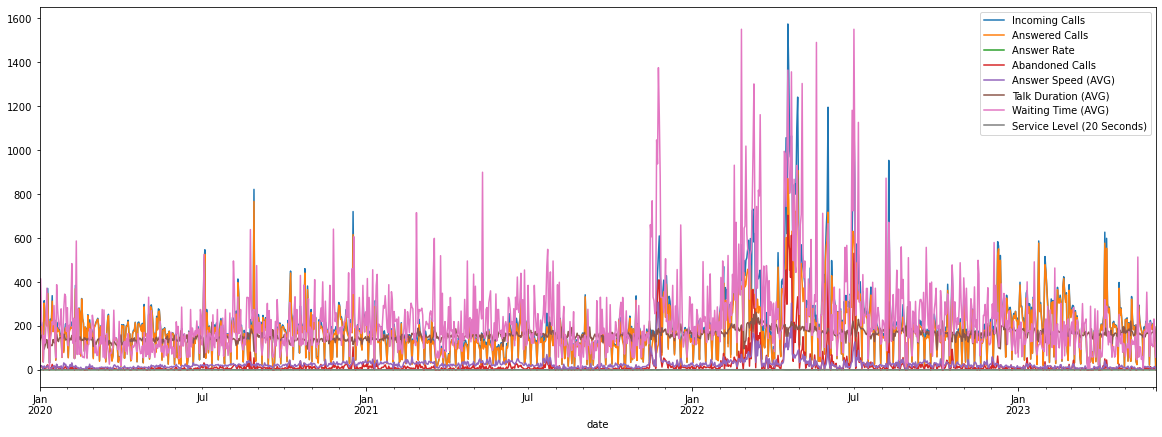

In [17]:
data = df.copy()
data.set_index("date", inplace=True)

data.plot(figsize=(20, 7))

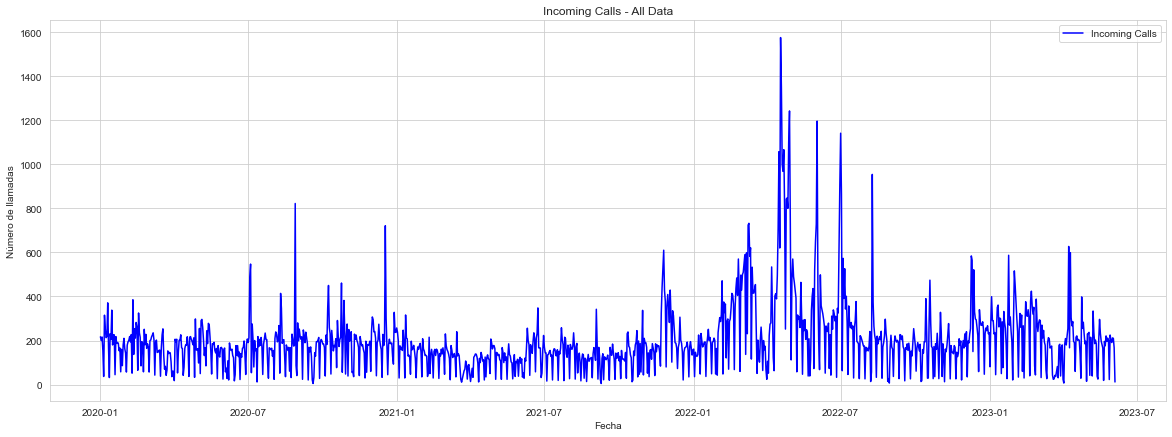

In [18]:
# Fondo Blanco
sns.set_style("whitegrid")

# Graficar la serie temporal de Incoming Calls
plt.figure(figsize=(20, 7))
plt.plot(df["date"], df['Incoming Calls'], label='Incoming Calls', color='b')
plt.title("Incoming Calls - All Data")
plt.xlabel("Fecha")
plt.ylabel("Número de llamadas")
plt.legend()
plt.show()

In [19]:
df.describe()

,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
count,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000
mean,198.539568,176.845723,0.927066,21.693845,24.897682,157.551559,232.314948,0.708777
std,156.534195,115.612080,0.084732,59.671955,23.717047,23.703087,190.647960,0.184520
min,5.000000,5.000000,0.220000,0.000000,2.000000,57.000000,3.000000,0.000000
25%,123.000000,114.000000,0.910000,3.000000,13.000000,142.000000,118.000000,0.600000
50%,177.000000,166.000000,0.950000,8.000000,21.000000,157.000000,182.000000,0.740000
75%,233.000000,214.500000,0.970000,16.000000,30.000000,171.000000,276.000000,0.840000
max,1575.000000,909.000000,1.000000,704.000000,308.000000,288.000000,1551.000000,1.000000


In [20]:
# Agregar variables estacionales
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofyear
df['week'] = df['date'].dt.isocalendar().week

df

,Fecha,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),date,year,month,day,week
0,2020-01-01,217,204,0.94,13,17,134,165,0.76,2020-01-01,2020,1,1,1
1,2020-01-02,200,182,0.91,18,20,142,415,0.73,2020-01-02,2020,1,2,1
2,2020-01-03,216,198,0.92,18,18,158,230,0.74,2020-01-03,2020,1,3,1
3,2020-01-04,155,145,0.94,10,15,149,192,0.80,2020-01-04,2020,1,4,1
4,2020-01-05,37,37,1.00,0,3,126,35,0.97,2020-01-05,2020,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,2023-05-31,191,184,0.96,7,7,170,116,0.93,2023-05-31,2023,5,151,22
1247,2023-06-01,212,209,0.99,3,10,171,105,0.89,2023-06-01,2023,6,152,22
1248,2023-06-02,210,203,0.97,7,12,202,232,0.85,2023-06-02,2023,6,153,22
1249,2023-06-03,167,159,0.95,8,16,196,162,0.83,2023-06-03,2023,6,154,22


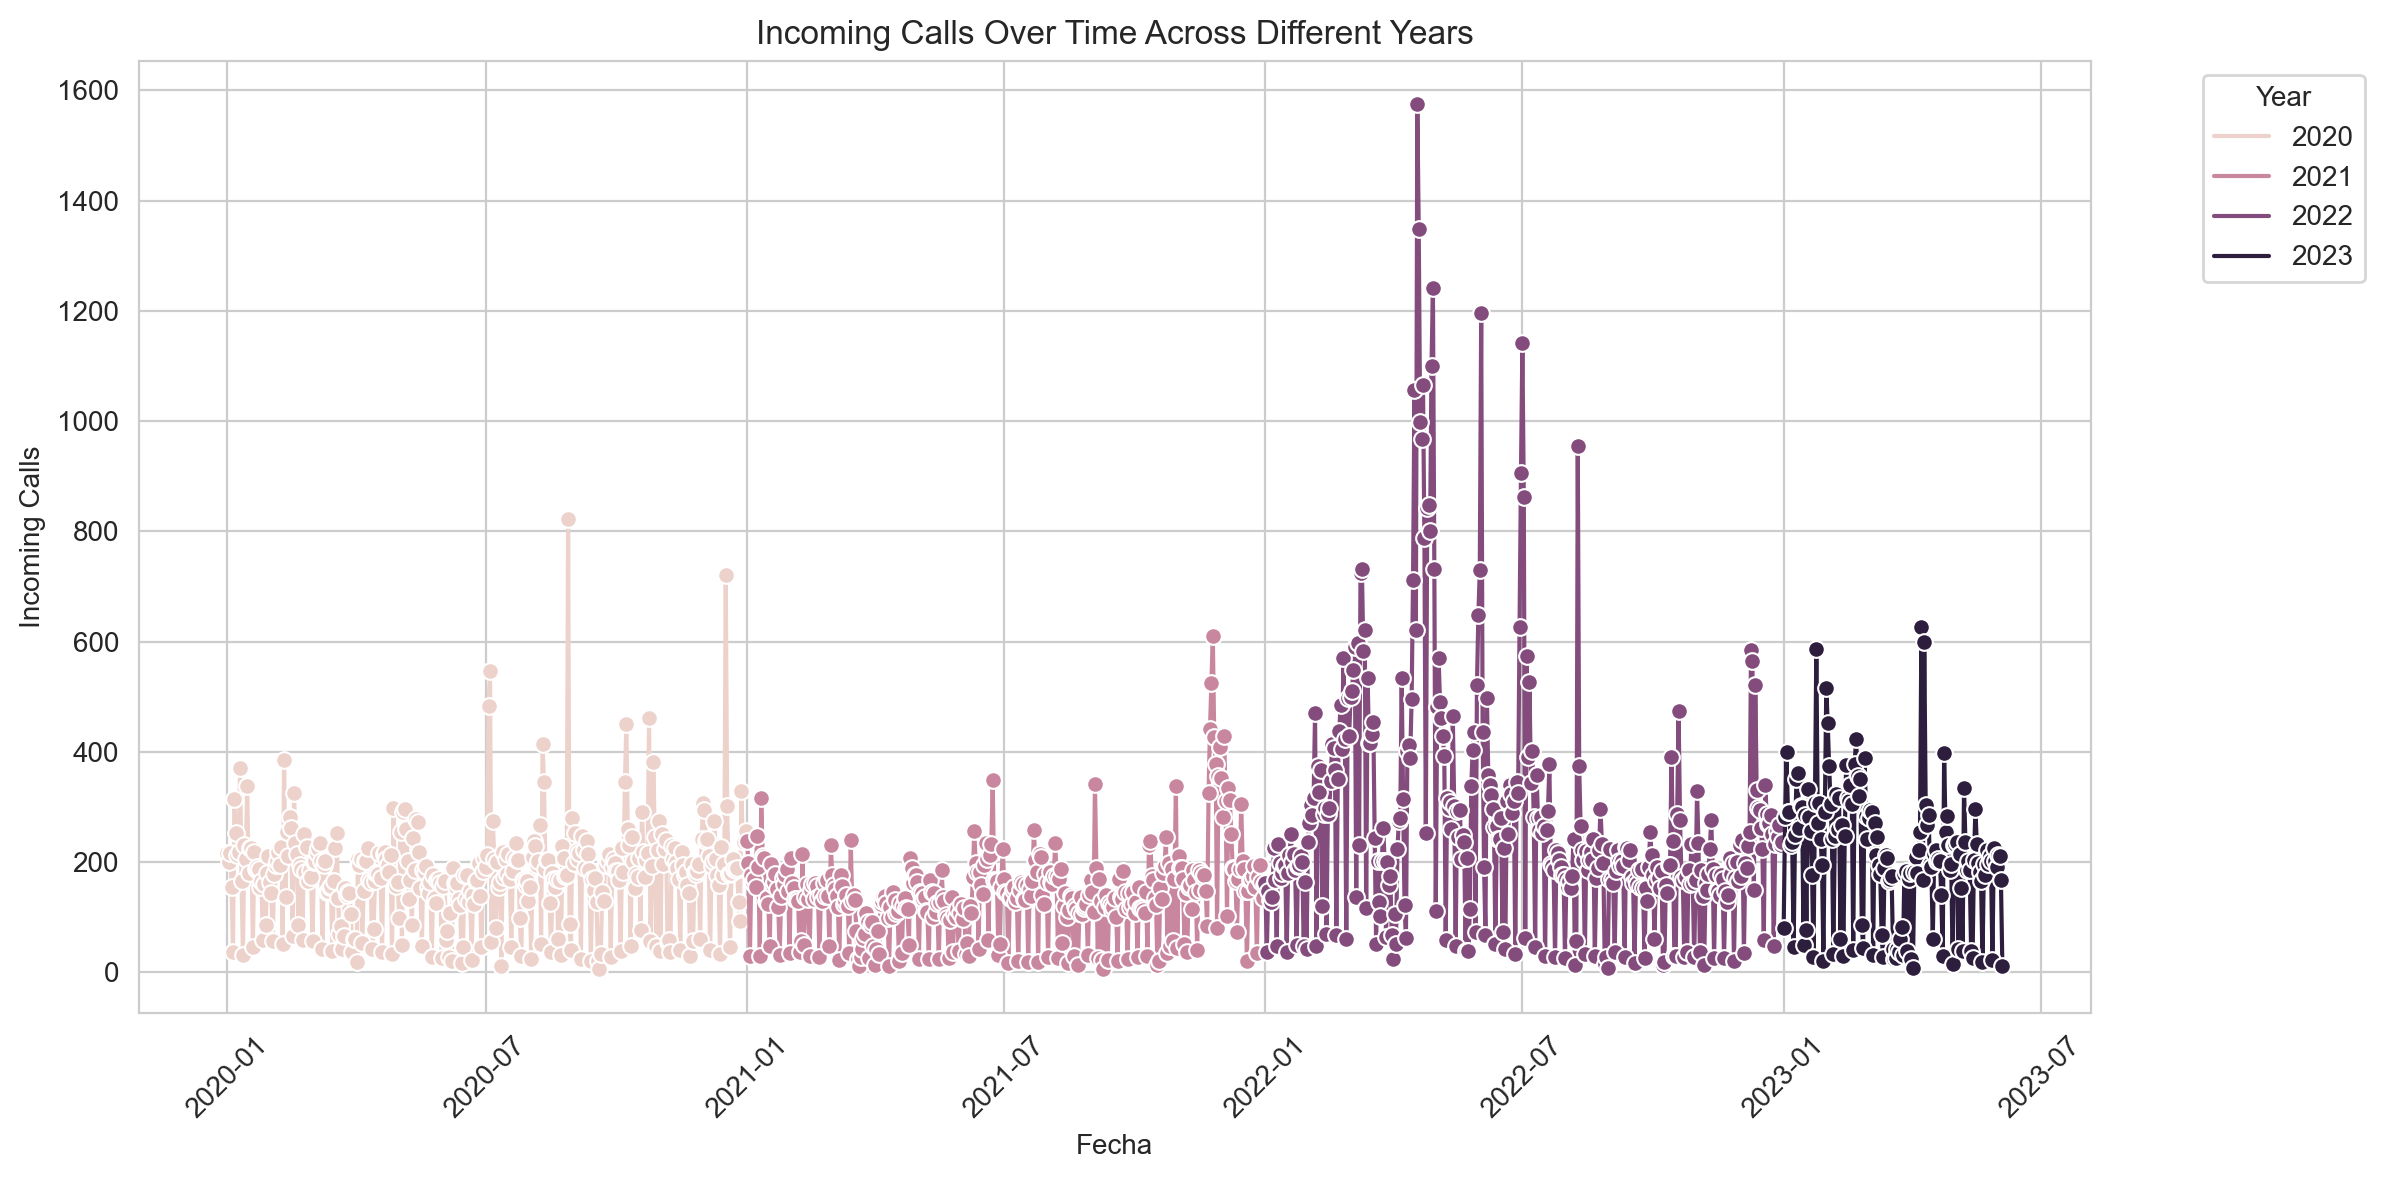

In [21]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=df, x='date', y='Incoming Calls', hue='year', marker='o')
plt.xlabel('Fecha')
plt.ylabel('Incoming Calls')
plt.title('Incoming Calls Over Time Across Different Years')
plt.xticks(rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

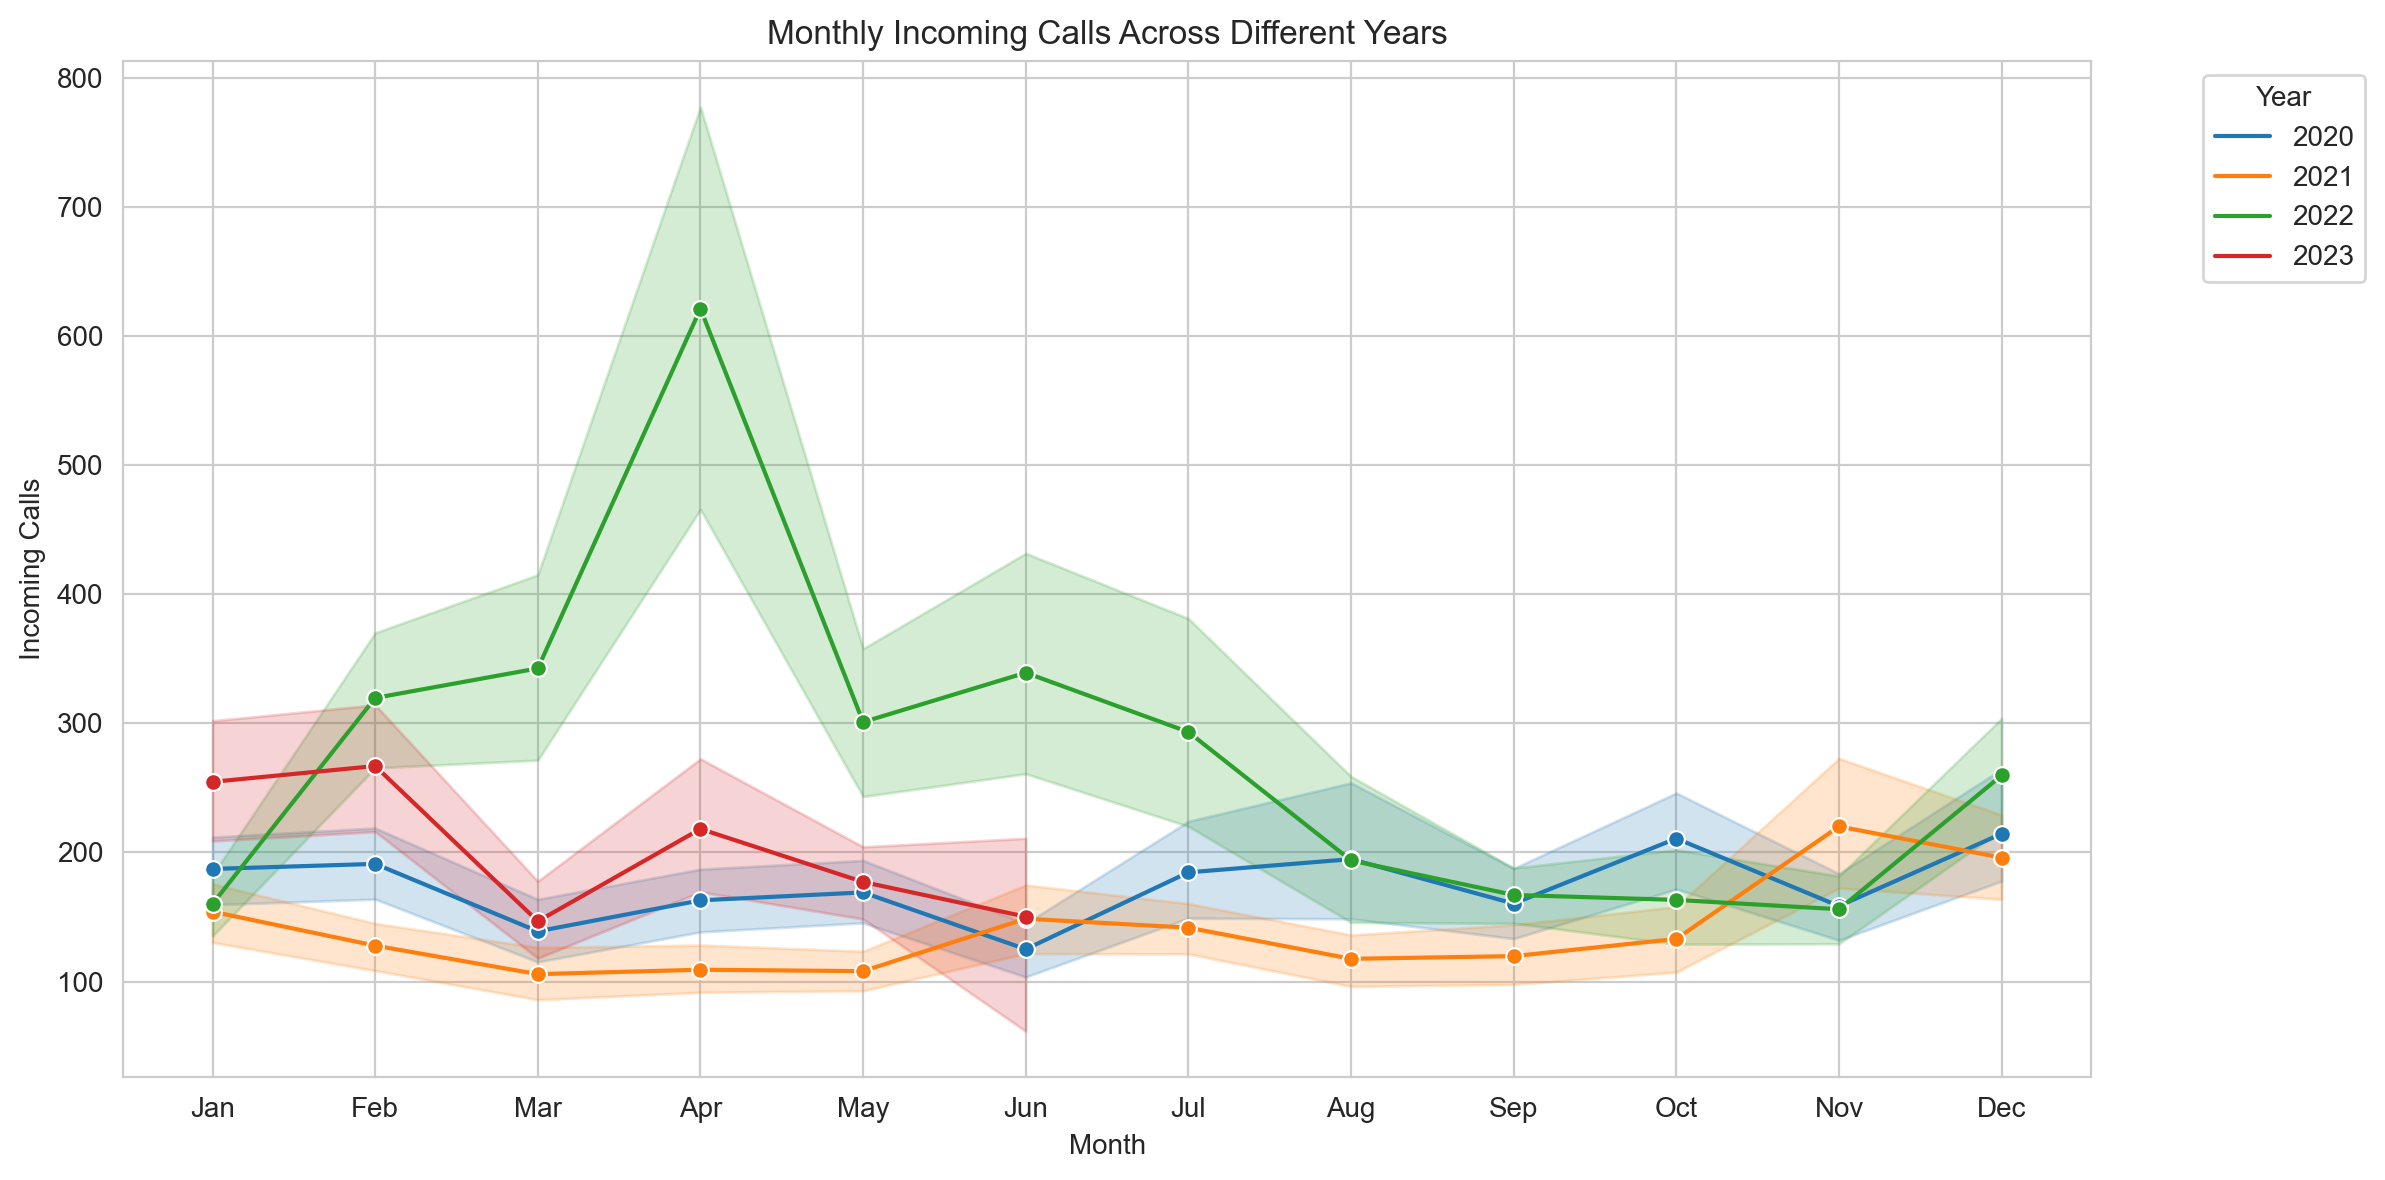

In [22]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=df, x='month', y='Incoming Calls', hue='year', marker='o', palette='tab10')
plt.xlabel('Month')
plt.ylabel('Incoming Calls')
plt.title('Monthly Incoming Calls Across Different Years')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

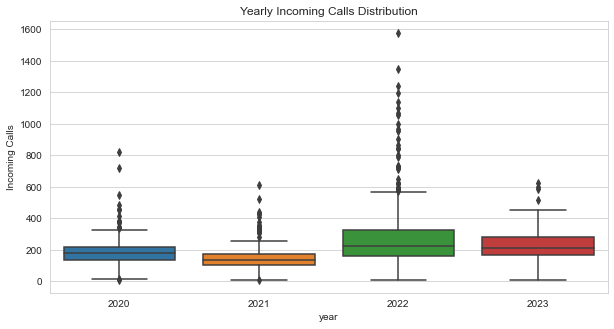

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='year', y='Incoming Calls', data=df)
plt.title("Yearly Incoming Calls Distribution")
plt.show()

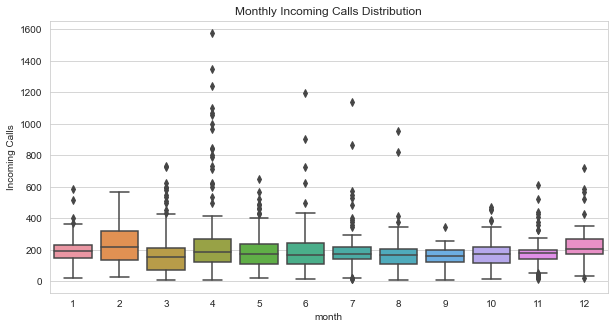

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='Incoming Calls', data=df)
plt.title("Monthly Incoming Calls Distribution")
plt.show()

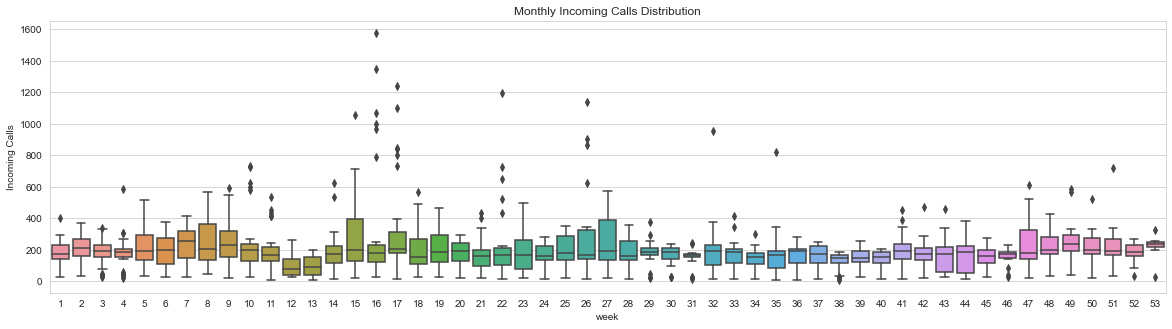

In [25]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='week', y='Incoming Calls', data=df)
plt.title("Monthly Incoming Calls Distribution")
plt.show()

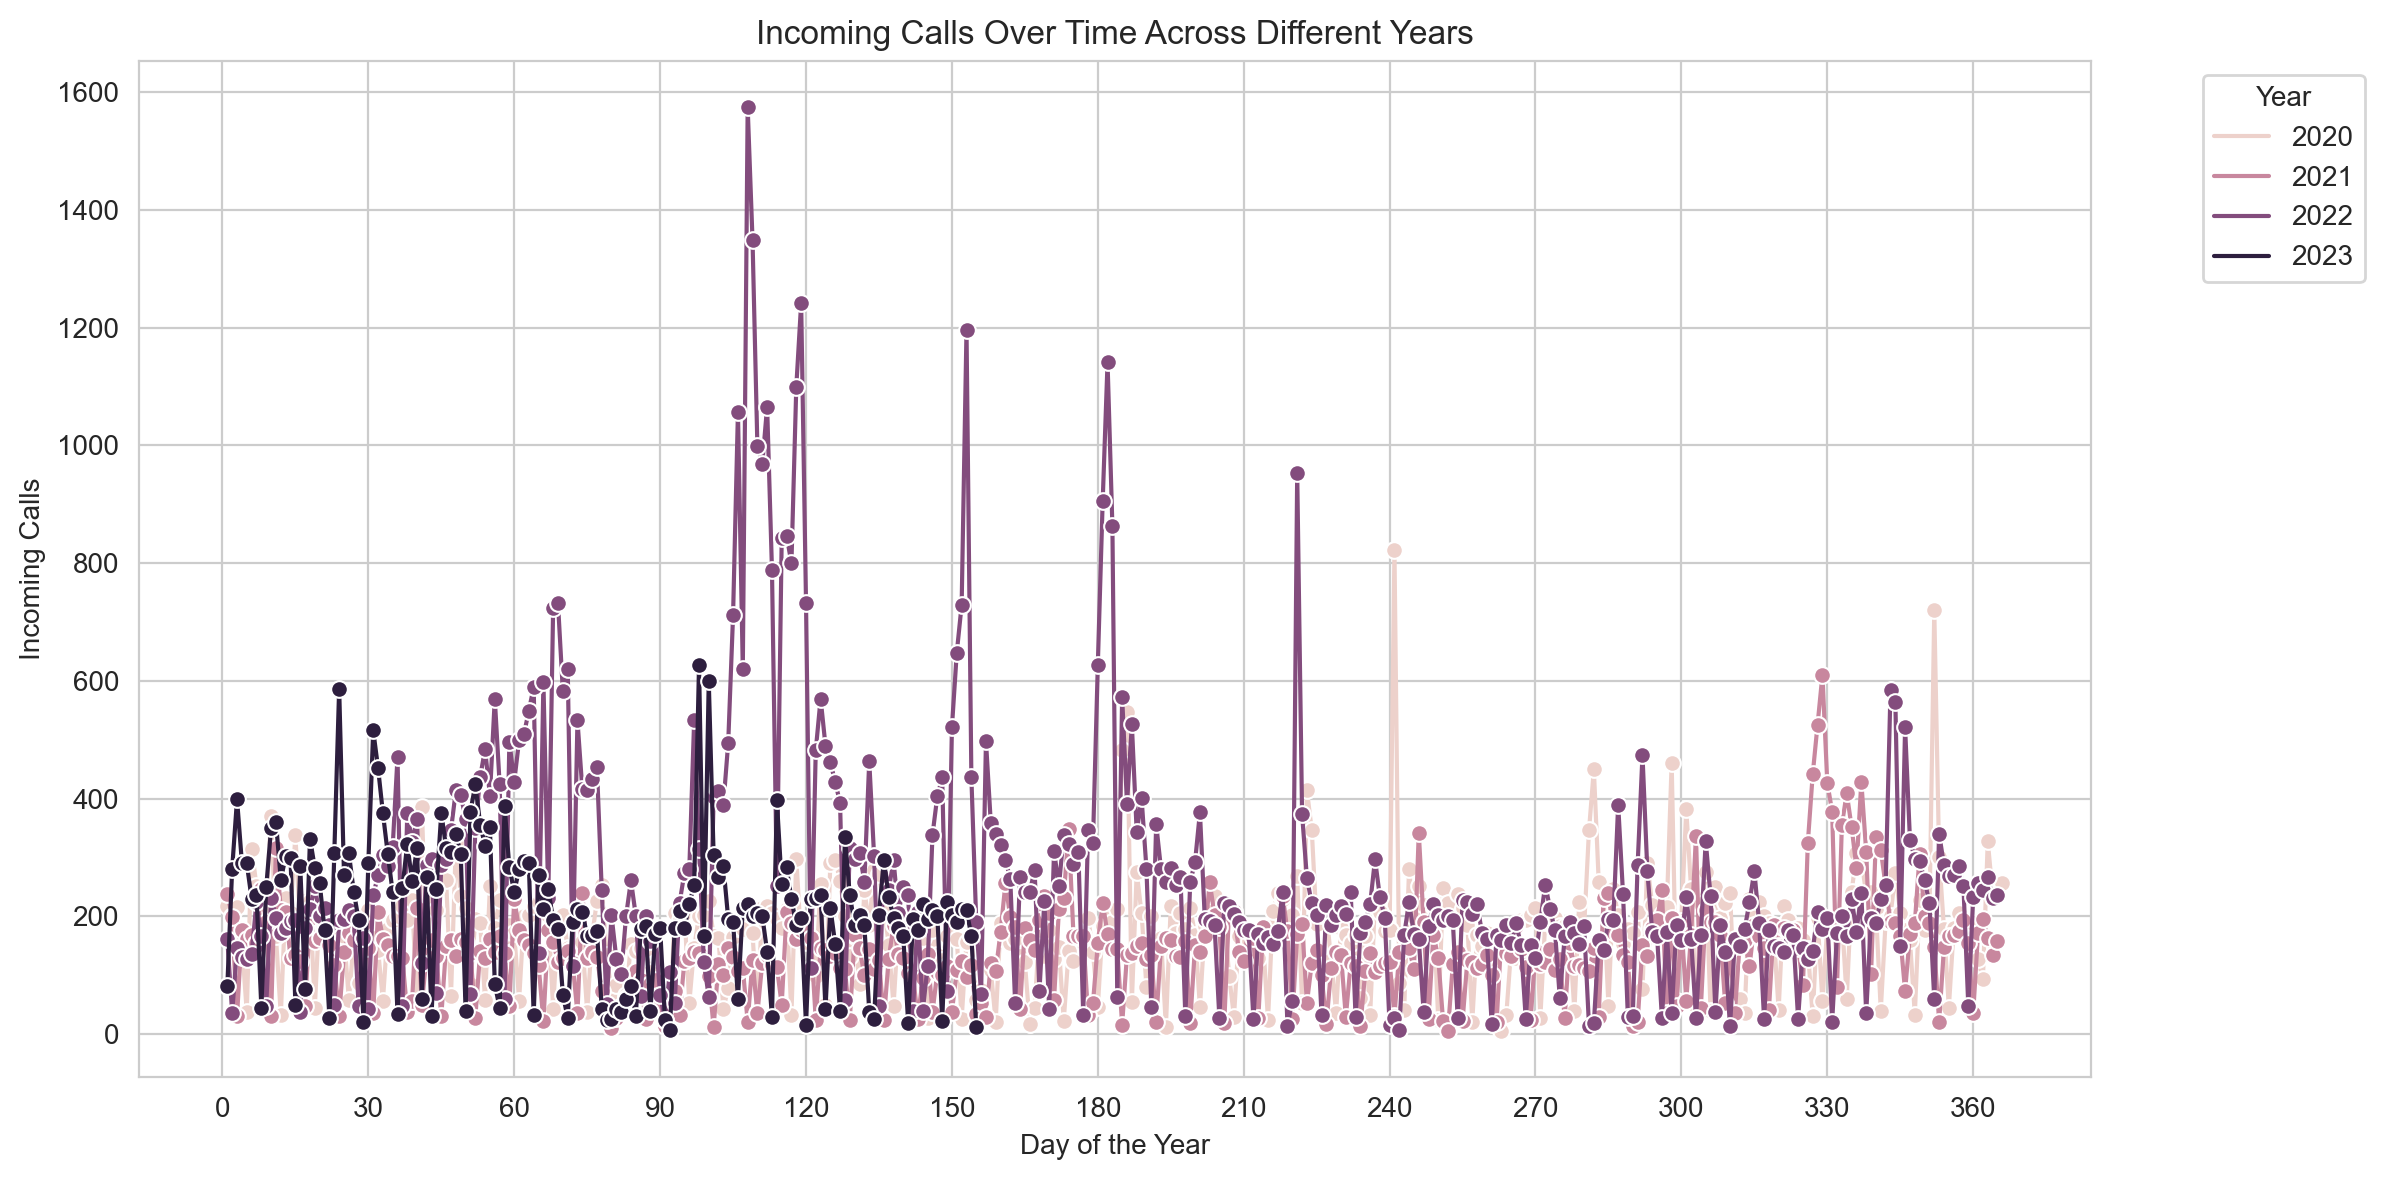

In [26]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=df, x='day', y='Incoming Calls', hue='year', marker='o')
plt.xlabel('Day of the Year')
plt.ylabel('Incoming Calls')
plt.title('Incoming Calls Over Time Across Different Years')
plt.xticks(range(0, 366, 30))
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Prueba de Dickey-Fuller para verificar estacionariedad**

Una serie es estacionaria si sus propiedades estadísticas, como la media, la varianza y la covarianza, son constantes a lo largo del tiempo.

Los modelos como ARIMA requieren que las series sean estacionarias para funcionar correctamente. Si no lo son, suele ser necesario transformar la serie (por ejemplo, mediante diferenciación).

In [27]:
from statsmodels.tsa.stattools import adfuller
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05: # P - Values
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")


In [28]:
Augmented_Dickey_Fuller_Test_func(df['Incoming Calls'],'Incoming Calls')

Resultados de la prueba de Dickey-Fuller para columna: Incoming Calls
Test Statistic                          -5.139832
p-value                                  0.000012
No Lags Used                            21.000000
Número de observaciones utilizadas    1229.000000
Critical Value (1%)                     -3.435682
Critical Value (5%)                     -2.863895
Critical Value (10%)                    -2.568024
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


# **Resultados explicados:**
**ADF Statistic:** -5.139832478157405

Este es el valor del estadístico de la prueba ADF. Es un número negativo, y cuanto más negativo sea, más evidencia tienes de que la serie es estacionaria.

**p-value:** 1.1651326523816478e-05 (muy cercano a 0)

Este es el valor p, que indica si puedes rechazar la hipótesis nula (H₀) de la prueba. La hipótesis nula en ADF es que la serie no es estacionaria (tiene raíz unitaria).

Un valor p muy pequeño (menor que un nivel de significancia común, como 0.05) indica que puedes rechazar H₀ y concluir que la serie es estacionaria. En tu caso, el valor p es extremadamente pequeño, por lo que tienes evidencia fuerte de estacionariedad.

**Lags Used:** 21

Representa el número de rezagos (lags) utilizados en la prueba. Los rezagos son valores anteriores de la serie que se incorporan en el modelo para capturar dinámicas temporales.

**Observations:** 1229

Es el número de observaciones restantes después de considerar los rezagos. Por ejemplo, si originalmente tenías 1250 datos y usaste 21 rezagos, el total restante sería 1229.

**Valores Críticos**


*  1%: -3.4356819860439574
*  5%: -2.863894574114006
*  10%: -2.568023609111511

Estos son los valores de referencia para diferentes niveles de significancia (1%, 5%, y 10%). Si el ADF Statistic es menor (más negativo) que uno de estos valores, puedes rechazar la hipótesis nula al nivel de significancia correspondiente.

En este caso, el ADF Statistic -5.139832 es más negativo que todos los valores críticos, incluyendo el del 1% (-3.435681). Esto significa que puedes rechazar la hipótesis nula con confianza incluso al nivel de significancia más estricto (1%).


In [31]:
import pmdarima as pm
# Encontrar los mejores valores de p y q automáticamente
model = pm.auto_arima(df['Incoming Calls'], d=0, seasonal=False, stepwise=True, trace=True, suppress_warnings=True)

# Mostrar los parámetros óptimos
print("Orden ARIMA óptima:", model.order)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15543.365, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=17394.619, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15845.357, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16633.728, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=15556.206, Time=0.82 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15554.351, Time=0.98 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=15539.790, Time=1.42 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=15555.998, Time=1.34 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=15488.764, Time=3.33 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=15557.982, Time=1.56 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=15524.487, Time=3.58 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=15414.072, Time=4.28 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=15459.785, Time=3.10 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=inf, Time=4.80 sec
 ARIMA(4,0,4)(0,0,0)[0]  